In [2]:
import torch
import torch.nn as nn

In [3]:
# 모델 구조 정의
class two_layer_mlp(nn.Module): 
    def __init__(self, dims):
        super().__init__()
        self.fc1 = nn.Linear(dims, 128)  # 인코더 
        self.fc2 = nn.Linear(128, dims)  # 디코더 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x1 = self.fc2(x)
        return x, x1  # x: matching, x1: projection

In [4]:
import pickle
def find_item_text(item, title_flag=True, description_flag=True):
    with open('./data/amazon/All_Beauty_text_name_dict.json.gz','rb') as ft: 
        text_name_dict = pickle.load(ft) 
    
    t = 'title'
    d = 'description'
    t_ = 'No Title'
    d_ = 'No Description'
    if title_flag and description_flag: # title과 description 모두 사용
        return [f'"{text_name_dict[t].get(i,t_)}, {text_name_dict[d].get(i,d_)}"' for i in item] # item에 대한 title과 description 반환
    elif title_flag and not description_flag:
        return [f'"{text_name_dict[t].get(i,t_)}"' for i in item]
    elif not title_flag and description_flag:
        return [f'"{text_name_dict[d].get(i,d_)}"' for i in item]

In [5]:
import torch
from pre_train.sasrec.utils import data_partition, SeqDataset
from utils import *
from pre_train.sasrec.model import SASRec
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer

device = torch.device('cpu')


cf_recsys_model_path = "./pre_train/sasrec/Luxury_Beauty/SASRec.epoch=200.lr=0.001.layer=2.head=1.hidden=50.maxlen=50.pth"
kwargs, checkpoint = torch.load(cf_recsys_model_path, map_location="cpu") 
kwargs['args'].device = 'cpu'
model = SASRec(**kwargs) # 모델 초기화 
model.load_state_dict(checkpoint) # 체크포인트 불러오기
    
for p in model.parameters(): # 모델의 파라미터를 고정시킴 (동결)
    p.requires_grad = False
    
# 모델 파일 경로
model_path1 = "./models/saved_models/Luxury_Beauty_sasrec_10_mlp.pt"
model_path2 = "./models/saved_models/Luxury_Beauty_sasrec_10_mlp2.pt"

# 두 모델 불러오기
model1 = two_layer_mlp(50)
model1.load_state_dict(torch.load(model_path1, map_location='cpu'))

model2 = two_layer_mlp(768)
model2.load_state_dict(torch.load(model_path2, map_location='cpu'))

for p in model1.parameters():  # 추가: MLP 모델1 파라미터 동결
    p.requires_grad = False

for p in model2.parameters():  # 추가: MLP 모델2 파라미터 동결
    p.requires_grad = False

# 학습된 SBERT 모델 불러오기
sbert_path = "./models/saved_models/Luxury_Beauty_sasrec_10_sbert.pt"

sbert = SentenceTransformer('nq-distilbert-base-v1')  
sbert.load_state_dict(torch.load(sbert_path, map_location='cpu'))
sbert.to(device)
sbert.eval()  # 평가 모드

dataset = data_partition('Luxury_Beauty', path='./data/amazon/All_Beauty.txt') 
[user_train, user_valid, user_test, usernum, itemnum] = dataset # 데이터셋 분할
num_batch = len(user_train) // 32

train_data_set = SeqDataset(user_train, usernum, itemnum, 50)
train_data_loader = DataLoader(train_data_set, batch_size = 32, pin_memory=True) 


/opt/anaconda3/envs/allm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/7b/yg613dfs6jqbpzd_hrdvrh1m0000gn/T/ipykernel_32737/2272197849.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glo

Initializing with num_user: 2413


In [6]:
print('user num:', usernum, 'item num:', itemnum)

user num: 2413 item num: 2151


In [7]:
for step, data in enumerate(train_data_loader): # batch_num 만큼 반복 (전체=1000개, 배치 사이즈=100 이면 10번 반복)
    u, seq, pos, neg = data # 배치 사이즈 만큼 로드 
    u, seq, pos, neg = u.numpy(), seq.numpy(), pos.numpy(), neg.numpy()
    
    indices = [50*(i+1)-1 for i in range(u.shape[0])]
    with torch.no_grad(): # gradient 계산 안하고 forward만 진행
        log_emb, pos_emb, neg_emb = model(u, seq, pos, neg, mode='item')
        
    log_emb_ = log_emb[indices] # 배치 유저의 마지막 상호작용 아이템의 임베딩
    pos_emb_ = pos_emb[indices] # 배치 유저의 마지막 positive 아이템(마지막 상호작용 아이템의 next item) 임베딩
    neg_emb_ = neg_emb[indices] # 배치 유저의 마지막 negative 아이템(상호작용X) 임베딩
    pos_ = pos.reshape(pos.size)[indices] # 배치 유저의 마지막 positive 아이템 인덱스
    neg_ = neg.reshape(neg.size)[indices] # 배치 유저의 마지막 negative 아이템 인덱스

    start_inx = 0 
    end_inx = 60 # 한 번에 60개의 유저를 학습하기 위해
    iterss = 0 
    while start_inx < len(log_emb_): # log_emb_의 길이(user 수)만큼 반복
        # 아이템 임베딩을 위한 과정
        log_emb = log_emb_[start_inx:end_inx] # 60명 유저의 마지막 아이템의 log_emb = user representation = x
        pos_emb = pos_emb_[start_inx:end_inx] # _emb = E_i
        neg_emb = neg_emb_[start_inx:end_inx] # _emb = E_i
        
        # 텍스트 임베딩을 위한 과정 
        pos__ = pos_[start_inx:end_inx] # pos_에서 start_inx부터 end_inx까지의 아이템 인덱스
        neg__ = neg_[start_inx:end_inx]
        
        start_inx = end_inx # start_inx를 end_inx로 변경
        end_inx += 60 
        iterss +=1
        
        # text embedding을 얻는 과정 
        pos_text = find_item_text(pos__) # item에 대한 title과 description, 각 아이템을 요소로 한 리스트 반환 
        neg_text = find_item_text(neg__)
        
        pos_token = sbert.tokenize(pos_text) # SBERT로 토큰화
        with torch.no_grad():   
            pos_text_embedding= sbert({'input_ids':pos_token['input_ids'].to(device),'attention_mask':pos_token['attention_mask'].to(device)})['sentence_embedding']
        # SBERT로 text embedding을 얻음
        neg_token = sbert.tokenize(neg_text)
        with torch.no_grad():
            neg_text_embedding= sbert({'input_ids':neg_token['input_ids'].to(device),'attention_mask':neg_token['attention_mask'].to(device)})['sentence_embedding']
        # _text_embedding = Q_i
        
        model1.to(device)
        model2.to(device)
        pos_text_embedding = pos_text_embedding.to(device)
        neg_text_embedding = neg_text_embedding.to(device)
        
        pos_text_matching, pos_proj = model1(pos_emb) # positive 아이템 임베딩을 MLP에 통과시킴
        neg_text_matching, neg_proj = model1(neg_emb) # negative 아이템 임베딩을 MLP에 통과시킴
        # matching: 햐나의 MLP layer를 통과시킨 것 (인코더 통과) e_i
        # proj: 두 번째 MLP layer를 통과시킨 것 (디코더 통과)
        
        pos_text_matching_text, pos_text_proj = model2(pos_text_embedding) # positive 아이템 텍스트 임베딩을 MLP에 통과시킴
        neg_text_matching_text, neg_text_proj = model2(neg_text_embedding) # negative 아이템 텍스트 임베딩을 MLP에 통과시킴
        
        break
    break

In [8]:
pos_text_matching_text

tensor([[0.3997, 0.5799, 0.4247,  ..., 0.6717, 0.5645, 0.5884],
        [0.4892, 0.4647, 0.4753,  ..., 0.5118, 0.4829, 0.4891],
        [0.4435, 0.4941, 0.4289,  ..., 0.5821, 0.4926, 0.5221],
        ...,
        [0.4485, 0.5042, 0.4261,  ..., 0.6049, 0.5456, 0.5452],
        [0.4672, 0.4706, 0.4872,  ..., 0.5871, 0.5088, 0.5256],
        [0.4683, 0.5355, 0.4704,  ..., 0.6454, 0.5112, 0.5460]])

In [9]:
# 한 명의 유저에 대해서 한 것임. 
print("Output from fc1 (Model 1):")
print(pos_text_matching)

print("Output from fc1 (Model 2):")
print(pos_text_matching_text)

Output from fc1 (Model 1):
tensor([[0.4704, 0.5203, 0.4287,  ..., 0.5508, 0.5288, 0.5080],
        [0.5305, 0.4347, 0.5182,  ..., 0.5397, 0.4608, 0.4668],
        [0.4921, 0.4370, 0.4898,  ..., 0.4913, 0.4185, 0.4983],
        ...,
        [0.4383, 0.4640, 0.4245,  ..., 0.4946, 0.4846, 0.5164],
        [0.4129, 0.5309, 0.4163,  ..., 0.6200, 0.5117, 0.5813],
        [0.5248, 0.5188, 0.5015,  ..., 0.5637, 0.4605, 0.5473]])
Output from fc1 (Model 2):
tensor([[0.3997, 0.5799, 0.4247,  ..., 0.6717, 0.5645, 0.5884],
        [0.4892, 0.4647, 0.4753,  ..., 0.5118, 0.4829, 0.4891],
        [0.4435, 0.4941, 0.4289,  ..., 0.5821, 0.4926, 0.5221],
        ...,
        [0.4485, 0.5042, 0.4261,  ..., 0.6049, 0.5456, 0.5452],
        [0.4672, 0.4706, 0.4872,  ..., 0.5871, 0.5088, 0.5256],
        [0.4683, 0.5355, 0.4704,  ..., 0.6454, 0.5112, 0.5460]])


In [10]:
pos_text_matching.shape, pos_text_matching_text.shape

(torch.Size([32, 128]), torch.Size([32, 128]))

## matching이 잘 되는지

In [11]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

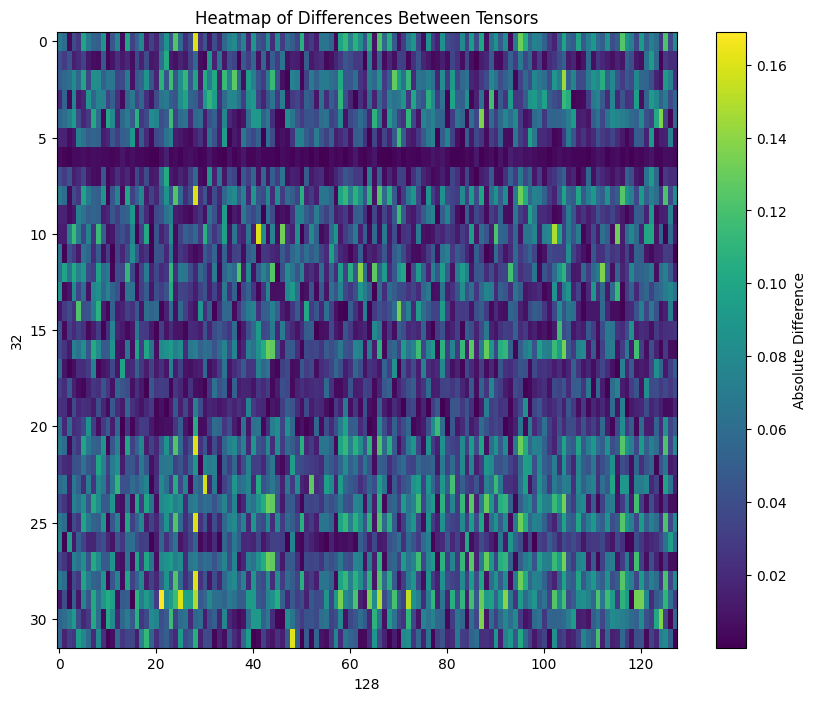

In [12]:
import torch
import matplotlib.pyplot as plt
# 1. 차이 계산
difference = torch.abs(pos_text_matching - pos_text_matching_text)  # 절대값 차이 계산

# 2. 히트맵 시각화
plt.figure(figsize=(10, 8))
plt.title("Heatmap of Differences Between Tensors")
plt.imshow(difference.numpy(), cmap="viridis", aspect="auto")
plt.colorbar(label="Absolute Difference")
plt.xlabel("128")
plt.ylabel("32")
plt.show()


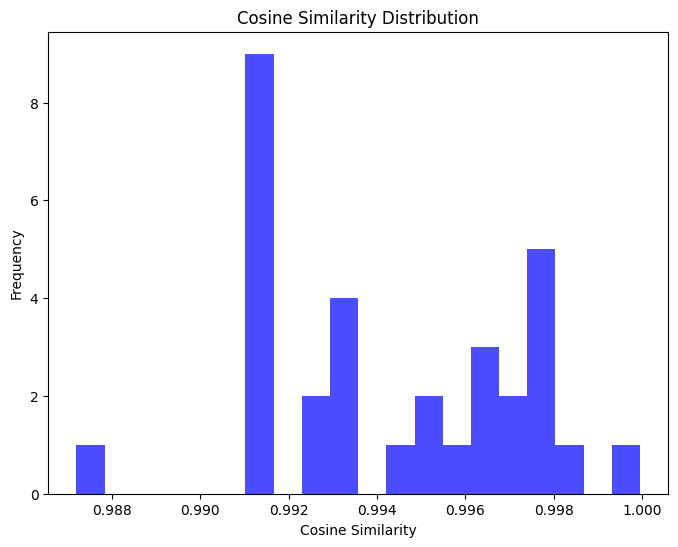

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# 코사인 유사도 계산
tensor1_np = pos_text_matching.numpy()
tensor2_np = pos_text_matching_text.numpy()
cosine_similarities = [cosine_similarity([t1], [t2])[0][0] for t1, t2 in zip(tensor1_np, tensor2_np)]

# 히스토그램으로 유사도 분포 확인
plt.figure(figsize=(8, 6))
plt.title("Cosine Similarity Distribution")
plt.hist(cosine_similarities, bins=20, color='blue', alpha=0.7)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


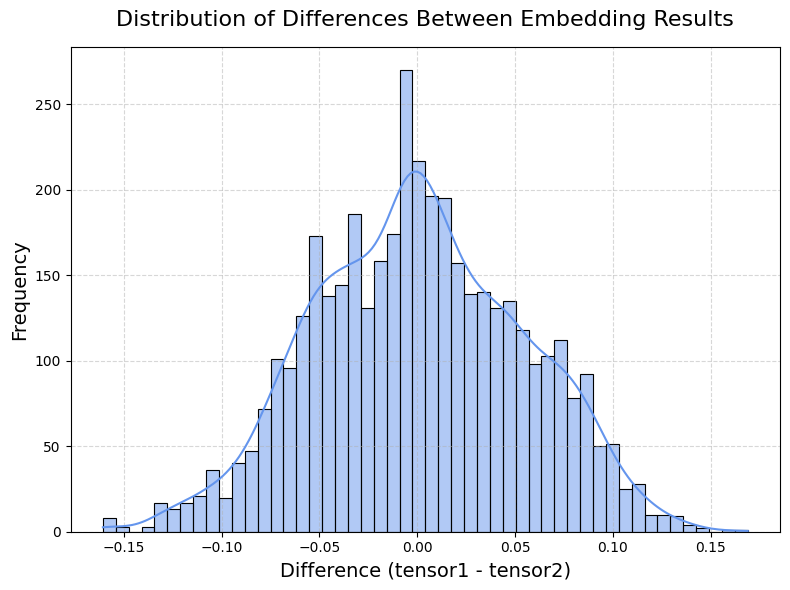

In [14]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 예제 데이터 생성 (32 x 128 크기)
tensor1 = pos_text_matching  # pos_text_matching
tensor2 = pos_text_matching_text  # pos_text_matching_text

# 값의 차이 계산 및 벡터화
difference = tensor1 - tensor2
difference_flat = difference.flatten()

# 히스토그램 시각화
plt.figure(figsize=(8, 6))
# 히스토그램 (Seaborn 사용으로 부드럽게)
sns.histplot(
    difference_flat.numpy(), 
    bins=50, 
    kde=True,  # 밀도 추정 곡선 추가
    color='cornflowerblue', 
    edgecolor='black'
)

# 그래프 제목 및 축 레이블
plt.title("Distribution of Differences Between Embedding Results", fontsize=16, pad=15)
plt.xlabel("Difference (tensor1 - tensor2)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# 시각적 요소 개선
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 디코더를 통과한거랑 차이가 큰지

In [15]:
pos_emb, pos_proj

(tensor([[-0.0209, -0.0755, -0.2222,  ..., -0.2745, -0.1448, -0.0693],
         [ 0.1284,  0.0136,  0.1933,  ..., -0.2170, -0.0443,  0.2124],
         [ 0.0499,  0.0299,  0.0373,  ..., -0.1465, -0.0697, -0.0567],
         ...,
         [-0.1806, -0.0187,  0.2714,  ...,  0.1763, -0.0640,  0.0478],
         [-0.2693, -0.0618,  0.3462,  ..., -0.3142,  0.2464, -0.4771],
         [ 0.2104, -0.1823,  0.1997,  ..., -0.1336,  0.1499, -0.3035]]),
 tensor([[-0.2074,  0.1528, -0.1294,  ..., -0.1027, -0.1260, -0.1376],
         [ 0.2817, -0.1713,  0.1137,  ...,  0.0679,  0.2374,  0.2300],
         [ 0.4407, -0.3173,  0.1778,  ...,  0.0939,  0.3642,  0.3127],
         ...,
         [ 0.3829, -0.2811,  0.2035,  ...,  0.1313,  0.3816,  0.3131],
         [-0.2996,  0.2912, -0.0805,  ..., -0.1672, -0.2828, -0.2807],
         [ 0.1495, -0.0939,  0.0739,  ...,  0.0132,  0.0834,  0.0805]]))

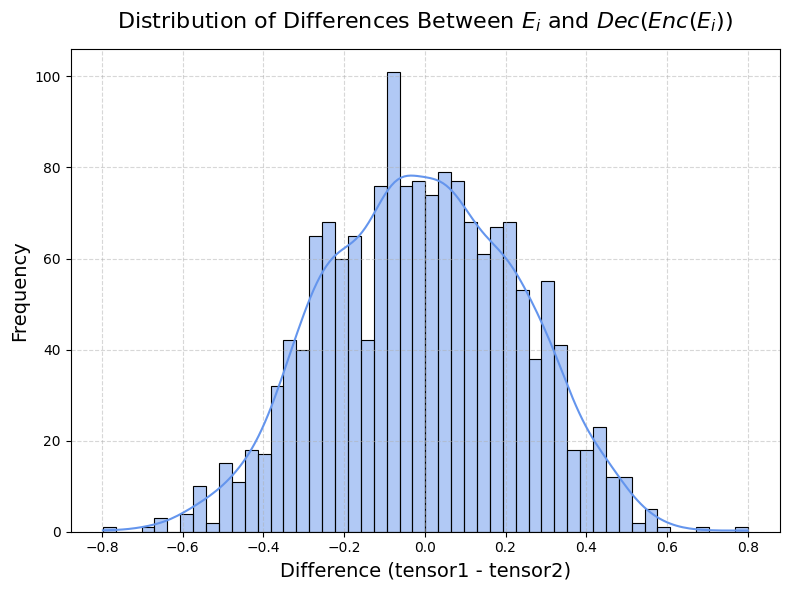

In [16]:
# 예제 데이터 생성 (32 x 128 크기)
tensor1 = pos_emb  # pos_text_matching
tensor2 = pos_proj  # pos_text_matching_text

# 값의 차이 계산 및 벡터화
difference = tensor1 - tensor2
difference_flat = difference.flatten()

# 히스토그램 시각화
plt.figure(figsize=(8, 6))
# 히스토그램 (Seaborn 사용으로 부드럽게)
sns.histplot(
    difference_flat.numpy(), 
    bins=50, 
    kde=True,  # 밀도 추정 곡선 추가
    color='cornflowerblue', 
    edgecolor='black'
)

# 그래프 제목 및 축 레이블
plt.title("Distribution of Differences Between $E_i$ and $Dec(Enc(E_i))$", fontsize=16, pad=15)
plt.xlabel("Difference (tensor1 - tensor2)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# 시각적 요소 개선
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [17]:
pos_text_embedding, pos_text_proj

(tensor([[ 0.0790, -0.1395, -0.1602,  ..., -0.1019, -0.0504, -0.1942],
         [ 0.0070, -0.0526,  0.1976,  ...,  0.1203,  0.0027,  0.0274],
         [ 0.0546,  0.0661,  0.0028,  ...,  0.0268,  0.0770, -0.0572],
         ...,
         [-0.1197,  0.0427, -0.0401,  ..., -0.1291, -0.0614, -0.1315],
         [ 0.0312, -0.0227,  0.0872,  ..., -0.0118,  0.0871,  0.0614],
         [ 0.1065, -0.0450, -0.0644,  ..., -0.0752,  0.1149, -0.1053]]),
 tensor([[-0.0899,  0.0350, -0.1400,  ..., -0.0714,  0.0347, -0.1776],
         [-0.0226,  0.0530,  0.1836,  ...,  0.0536, -0.0235,  0.0244],
         [-0.0535,  0.0323,  0.0417,  ...,  0.0244,  0.0091, -0.0597],
         ...,
         [-0.0615,  0.0445,  0.0090,  ..., -0.0395,  0.0006, -0.0838],
         [-0.0484,  0.0329,  0.0904,  ...,  0.0223, -0.0153, -0.0218],
         [-0.0517,  0.0401,  0.0201,  ..., -0.0175,  0.0029, -0.0871]]))

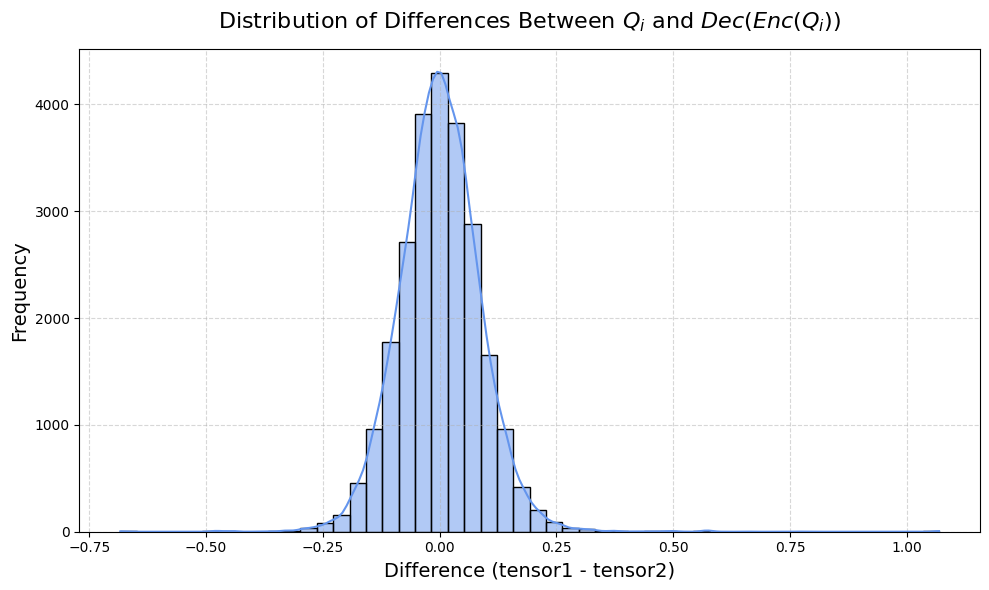

In [18]:
# 예제 데이터 생성 (32 x 128 크기)
tensor1 = pos_text_embedding  # pos_text_matching
tensor2 = pos_text_proj  # pos_text_matching_text

# 값의 차이 계산 및 벡터화
difference = tensor1 - tensor2
difference_flat = difference.flatten()

# lowest_values, _ = torch.topk(difference_flat, k=20, largest=False)  # 가장 낮은 3개 값
# difference_without_min3 = difference_flat[~torch.isin(difference_flat, lowest_values)]

# 히스토그램 시각화
plt.figure(figsize=(10, 6))

# 히스토그램 (Seaborn 사용으로 부드럽게)
sns.histplot(
    difference_flat.numpy(), 
    bins=50, 
    kde=True,  # 밀도 추정 곡선 추가
    color='cornflowerblue', 
    edgecolor='black'
)

# 그래프 제목 및 축 레이블
plt.title("Distribution of Differences Between $Q_i$ and $Dec(Enc(Q_i))$", fontsize=16, pad=15)
plt.xlabel("Difference (tensor1 - tensor2)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# 시각적 요소 개선
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
count_less_than_neg4 = torch.sum(difference_flat > 0.3).item()
print(f"Number of elements less than -4: {count_less_than_neg4}")

Number of elements less than -4: 64
